---
**Outline**

1. Review - Scorecard Development Process
2. End-to-End Example of Scorecard Creation

In [1]:
# Load data manipulation package
import numpy as np
import pandas as pd
import itertools

# Load data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

**1. Explore data.**
  - Simple statistics such as distributions of values, mean/median, etc.
  - Checking data integrity.

**2. Handle missing values and outliers.**
  - Most financial industry data contains missing values, or values that do not make sense for a particular characteristic

**3. Check correlation.**

**4. Initial characteristic analysis.**
  - To assess the strength of each characteristic individually as a predictor of performance.

**5. Statistical Measures.**
  - Weight of Evidence (WoE) — measures the strength of each attribute.
  - Information Value (IV) — measures the total strength of the characteristic.

**6. Check logical trend.**
  - Attribute strengths must also be in a logical order, and make operational sense.

**7. Check business/operational considerations.**
  - The consideration is business or operational relevance. e.g. postal codes.

**8. Design scorecards.**
  - Preliminary scorecard
  - Reject inference —
To make educated guesses about how rejected applicants would have performed if accepted.
  - Final scorecard production

**9. Choose a scorecard** — using a combination of statistical and business measures.
  - For example: misclassification, scorecard strength (KS, Chi-square, AIC, AUC), etc.






# **Example of Scorecard Creation**
---

This is an end-to-end example to show how a scorecard is
created.

This is a highly simplified one, designed to show how the
final scores are calculated.

The sample we will use in this example is a fictive dataset from [here](https://www.kaggle.com/datasets/laotse/credit-risk-dataset).

The sample consist of some demographic, bureau, and financial information.

Note that we are not defining the default or bad status from our dataset here. Instead, we already have the binary response variable:

- `loan_status`
  - `loan_status = 0` for non default loan.
  - `loan_status = 1` for default loan.

The potential characteristics for predicting the response variable are:

1. `person age`
2. `person_income` (the annual income of the debtor)
3. `person_home_ownership`
  - `RENT`
  - `MORTGAGE`
  - `OWN`
  - `OTHER`
4. `person_emp_length` (the employment length of debtor in years)
5. `loan_intent` (the purpose of loan)
  - `EDUCATION`
  - `MEDICAL`
  - `VENTURE`
  - `PERSONAL`
  - `DEBTCONSOLIDATION`
6. `loan_grade`
7.  `loan_amnt`	(loan amount)
8. `loan_int_rate`	(interest rate)
10. `loan_percent_income`	(percent loan of income)
11. `cb_person_default_on_file`	(historical default)
  - `0` : the debtor does not have any history of defaults.
  - `1` : the debtor has a history of defaults on their credit file.
12. `cb_preson_cred_hist_length` (credit history length)

##  **1.Import Dataset**

In [2]:
# Import dataset from csv file
dataset = pd.read_csv('credit_risk_dataset.csv')

# Table check
dataset.head().T

,0,1,2,3,4
person_age,22,21,25,23,24
person_income,59000,9600,9600,65500,54400
person_home_ownership,RENT,OWN,MORTGAGE,RENT,RENT
person_emp_length,123.0,5.0,1.0,4.0,8.0
loan_intent,PERSONAL,EDUCATION,MEDICAL,MEDICAL,MEDICAL
loan_grade,D,B,C,C,C
loan_amnt,35000,1000,5500,35000,35000
loan_int_rate,16.02,11.14,12.87,15.23,14.27
loan_status,1,0,1,1,1
loan_percent_income,0.59,0.1,0.57,0.53,0.55


In [3]:
# Check data shape
dataset.shape

(32581, 12)

Our sample contains 12 variables from 32,581 credit records.
- 1 response variable, `loan_status`,
- and 11 potential characteristics/predictors.

Please note that in this example, we will use only 3 predictors, for the sake of simplicity.
- Predictor 1: `person_age`
- Predictor 4: `person_emp_length`
- Predictor 11: `cb_person_default_on_file`

In [4]:
data1 = dataset.copy()

# Use only 3 predictors and 1 response variable
data1 = dataset[['person_age',
             'person_emp_length',
             'cb_person_default_on_file',
             'loan_status']]
data1.head()

,person_age,person_emp_length,cb_person_default_on_file,loan_status
0,22,123.0,Y,1
1,21,5.0,N,0
2,25,1.0,N,1
3,23,4.0,N,1
4,24,8.0,Y,1


Before modeling, make sure you split the data first for model validation.

In the classification case, check the proportion of response variable first to decide the splitting strategy.

In [5]:
# Define response variable
response_variable = 'loan_status'

# Check the proportion of response variable
data1[response_variable].value_counts(normalize = True)

0    0.781836
1    0.218164
Name: loan_status, dtype: float64

The proportion of the response variable, `loan status`, is not quite balanced (in a ratio of 78:22).

To get the same ratio in training and testing set, define a stratified splitting based on the response variable, `loan_status`.

##  **2.Sample Split**

In [6]:
# Split response and predictors
y = data1[response_variable]
X = data1.drop(columns = [response_variable],
              axis = 1)

# Validate the splitting
print('y shape :', y.shape)
print('X shape :', X.shape)

y shape : (32581,)
X shape : (32581, 3)


In [7]:
X.head()

,person_age,person_emp_length,cb_person_default_on_file
0,22,123.0,Y
1,21,5.0,N
2,25,1.0,N
3,23,4.0,N
4,24,8.0,Y


Next, split the training and testing set from each predictors (X) and response (y).
- Set `stratify = y` for splitting the sample with stratify, based on the proportion of response y.
- Set `test_size = 0.3` for holding 30% of the sample as a testing set.
- Set `random_state = 42` for reproducibility.

In [8]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify = y,
                                                    test_size = 0.3,
                                                    random_state = 42)

# Validate splitting
print('X train shape :', X_train.shape)
print('y train shape :', y_train.shape)
print('X test shape  :', X_test.shape)
print('y test shape  :', y_test.shape)

X train shape : (22806, 3)
y train shape : (22806,)
X test shape  : (9775, 3)
y test shape  : (9775,)


Check the proportion of response y in each training and testing set.

In [9]:
y_train.value_counts(normalize = True)

0    0.781856
1    0.218144
Name: loan_status, dtype: float64

In [10]:
y_test.value_counts(normalize = True)

0    0.78179
1    0.21821
Name: loan_status, dtype: float64

## **3. Exploratory Data Analysis**

In [11]:
X_train.head()

,person_age,person_emp_length,cb_person_default_on_file
11491,26,1.0,N
3890,23,3.0,N
17344,24,1.0,N
13023,24,1.0,N
29565,42,4.0,N


In [12]:
X_test.head()

,person_age,person_emp_length,cb_person_default_on_file
28004,27,4.0,N
15942,26,NaN,N
26343,28,5.0,Y
16374,22,1.0,N
27301,29,13.0,N


In [13]:
y_train.head()

11491    0
3890     0
17344    1
13023    0
29565    1
Name: loan_status, dtype: int64

In [14]:
X_test.head()

,person_age,person_emp_length,cb_person_default_on_file
28004,27,4.0,N
15942,26,NaN,N
26343,28,5.0,Y
16374,22,1.0,N
27301,29,13.0,N


In [15]:
# Concatenate X_train and y_train as data_train
data_train = pd.concat((X_train, y_train),
                       axis = 1)

# Validate data_train
print('Train data shape:', data_train.shape)
data_train.head()

Train data shape: (22806, 4)


,person_age,person_emp_length,cb_person_default_on_file,loan_status
11491,26,1.0,N,0
3890,23,3.0,N,0
17344,24,1.0,N,1
13023,24,1.0,N,0
29565,42,4.0,N,1


What do we do in EDA?
- Check data integrity.
- Check for any insight in the data: distribution, proportion, outliers, missing values, etc.
- Make a plan for data pre-processing.

### Check for Missing Values

In [16]:
# Check for missing values
data_train.isna().sum()

person_age                     0
person_emp_length            639
cb_person_default_on_file      0
loan_status                    0
dtype: int64

In [17]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22806 entries, 11491 to 10456
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   person_age                 22806 non-null  int64  
 1   person_emp_length          22167 non-null  float64
 2   cb_person_default_on_file  22806 non-null  object 
 3   loan_status                22806 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 890.9+ KB


**Summary**
- There are missing values in `person_emp_length`, a numerical/float variable.
- We need to find how to handle the missing values by exploring this variable.

### Predictor 1: person_age

In [18]:
# Descriptive statistics of 'person_age'
data_train['person_age'].describe()

count    22806.000000
mean        27.722880
std          6.336638
min         20.000000
25%         23.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64

**Summary**
- There are customer who are 144 years old, whereas the indonesian age expectancy only 75


<AxesSubplot: xlabel='person_age', ylabel='Count'>

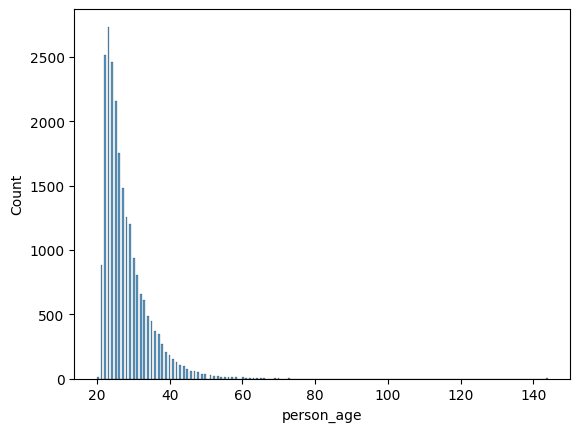

In [19]:
# Distribution plot of person_age
sns.histplot(data = data_train,
             x = 'person_age')

**Summary**
- There distribution is left skewed, so  i'm not use mean but median
- Based on dataset, the age's median is 26 years old which is most of applicant is 26 years old( relatively young)


In [20]:
# Descriptive of person_age by response loan_status
dataset['person_age'].groupby(data_train[response_variable]).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0.0,17831.0,27.784981,6.337859,20.0,23.0,26.0,30.0,144.0
1.0,4975.0,27.500302,6.327888,20.0,23.0,26.0,30.0,70.0


<AxesSubplot: xlabel='loan_status', ylabel='person_age'>

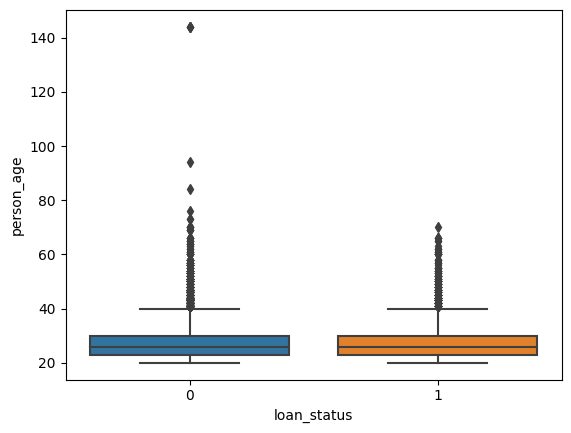

In [21]:
# Boxplot of person_age by response loan_status
sns.boxplot(data = data_train,
            x = response_variable,
            y = 'person_age')

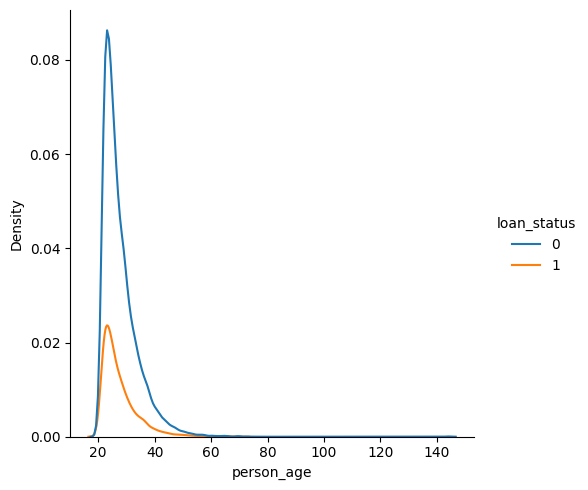

In [22]:
# Distribution plot of person_age by response loan_status
sns.displot(data = data_train,
            x = 'person_age',
            hue = response_variable,
            kind = 'kde')

**Summary**
- Based on visualization above, applicant who default or not have same median but what makes diffrence is outlier on applicant who are 80 and 144 years old
- Are there applicant who is 80 and 144 years old?

We may assume there are outliers for the age over 80 years old.

But we can check the maximum threshold for outliers from the IQR method below.

In [23]:
# Calculate Q1 and Q3
Q1_person_age = np.percentile(data_train['person_age'], 25)
Q3_person_age = np.percentile(data_train['person_age'], 75)

# Calculate IQR
IQR_person_age = Q3_person_age - Q1_person_age

# Calculate the thresholds
min_person_age = Q1_person_age - 1.5*IQR_person_age
max_person_age = Q3_person_age + 1.5*IQR_person_age

min_person_age, max_person_age

(12.5, 40.5)

From the IQR, debtors younger than 12.5 years and older than 40.5 years are outliers.

Assumptions:
- The age regulation for the applicant is a minimum of 21 years old.
- Applicants older than 40.5 to 55 may still be in productive age.

Therefore, we can define outliers from `person_age` variable with the following condition.

In [24]:
# Define minimum and maximum age with adjustment
adj_min_person_age = 21
adj_max_person_age = 55

# Define outliers
outliers_person_age_min = data_train['person_age'] < 21
outliers_person_age_max = data_train['person_age'] > 55

outliers_person_age = np.where(outliers_person_age_min | outliers_person_age_max)[0]

# Check the number of outliers in data_train
len(outliers_person_age)



114

In [25]:
outliers_person_age

array([  461,   634,   643,   799,   814,   863,  1196,  1254,  1460,
        1580,  1651,  1775,  2073,  2312,  2618,  2774,  3168,  3617,
        3817,  4033,  4199,  4230,  4513,  4606,  4637,  5008,  5264,
        5369,  5426,  5460,  5558,  5596,  5720,  5767,  5781,  5995,
        6233,  6365,  6368,  6451,  6575,  6666,  7166,  7273,  7451,
        7507,  7707,  8641,  8701,  8814,  9284,  9899,  9904, 10161,
       10240, 10435, 10926, 10975, 11082, 11164, 11709, 11817, 11864,
       12540, 12687, 13140, 13179, 13324, 13493, 13536, 13695, 13824,
       14396, 14672, 14704, 14786, 15043, 15114, 15171, 15324, 15747,
       16100, 16313, 16677, 16875, 17294, 17360, 17362, 17369, 17412,
       17495, 17695, 18354, 18376, 18655, 19332, 19536, 19626, 19790,
       19888, 19914, 20035, 20456, 20706, 20797, 21201, 21580, 21797,
       22011, 22073, 22151, 22274, 22437, 22782])

In [26]:
data_train['person_age'].isna().sum()

0

**Summary**

- There seems to be no age difference between the default and non-default groups.
- Potential outliers over 80 years old come from the non-default group.
- The youngest debtor is 20 years old.
- Three-quarters of the debtors are up to 30 years old. The rest are over 30 years old.

**Business Insight:**
- Check the regulations to see whether we will accept applicants aged 20 years.
- If not, are debtors aged 20 still included in the sample?
- Check the maximum age limit for the applicant and adjust it to the tenor.

**Pre-processing Plan:**
- There are no missing values.
- The outliers will be grouped.

### Predictor 1: person_emp_length

In [27]:
## Desc Stat of emp_length
data_train['person_emp_length'].describe()

count    22167.000000
mean         4.796905
std          4.120061
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        123.000000
Name: person_emp_length, dtype: float64

<AxesSubplot: xlabel='person_emp_length', ylabel='Count'>

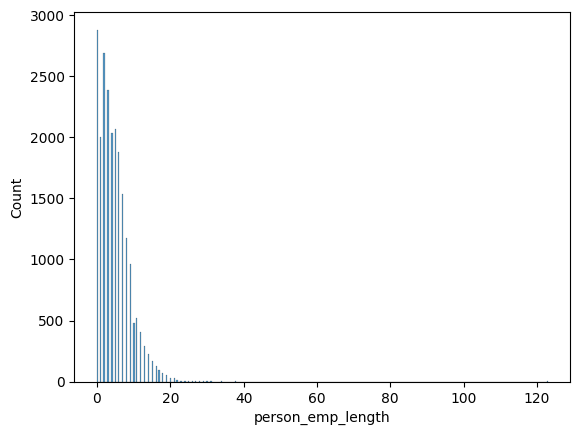

In [28]:
# Distribution plot of person_emp_length
sns.histplot(data = data_train,
             x = 'person_emp_length')

In [29]:
# Descriptive of person_emp_length by response loan_status
data_train['person_emp_length'].groupby(data_train[response_variable]).describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
0,17388.0,4.978951,4.161727,0.0,2.0,4.0,7.0,123.0
1,4779.0,4.134547,3.894015,0.0,1.0,3.0,6.0,34.0


<AxesSubplot: xlabel='loan_status', ylabel='person_emp_length'>

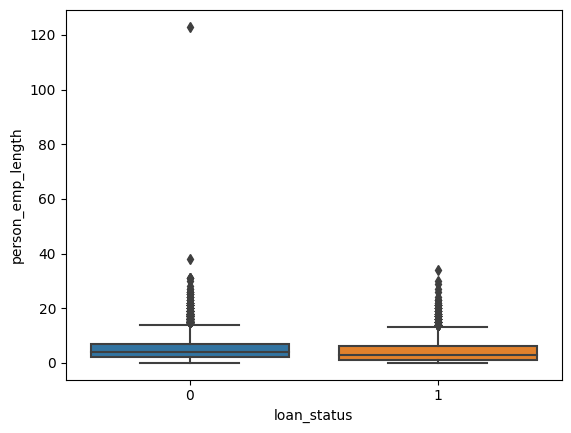

In [30]:
# Boxplot of person_emp_length by response loan_status
sns.boxplot(data = data_train,
            x = response_variable,
            y = 'person_emp_length')

**Summary**
- There distribution is right skewed, because there are potentially outlier, which is applicant who have 123 working experience
- Mostly applicant have 4 years working experience
- 

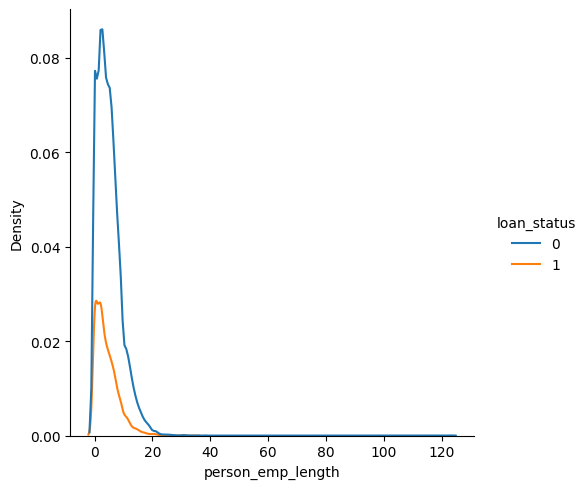

In [31]:
# Distribution plot of person_emp_length by response loan_status
sns.displot(data = data_train,
            x = 'person_emp_length',
            hue = response_variable,
            kind = 'kde')

In [32]:
# Check data integrity
# Check if there any employee is working at age is permitted to working (underage)
# There are 5475 employee is underage
underage_workers = (data_train['person_age'] - data_train['person_emp_length']) < 18

data_train[underage_workers]

,person_age,person_emp_length,cb_person_default_on_file,loan_status
25029,27,11.0,N,0
179,24,8.0,N,0
11278,25,9.0,N,0
13547,22,6.0,N,0
17324,23,7.0,N,1
...,...,...,...,...
13675,26,10.0,N,0
14989,24,8.0,N,0
10023,23,7.0,N,0
1663,22,7.0,N,0


In [33]:
# Check the proportion of underage workers
len(data_train[underage_workers])/len(data_train)

0.24006840305182847

In [75]:
# Check data integrity
invalid_workers =  data_train['person_emp_length'] > data_train['person_age']

data_train[invalid_workers]

,person_age,person_emp_length,cb_person_default_on_file,loan_status
210,21,123.0,N,0


- There is one invalid data where the employment's length exceeds the debtor's age.
- About 24% of debtors from the training set are debtors who started working before the age of 18 years. Does regulation permit it? check with legal department
 - Do they come from the same distribution?

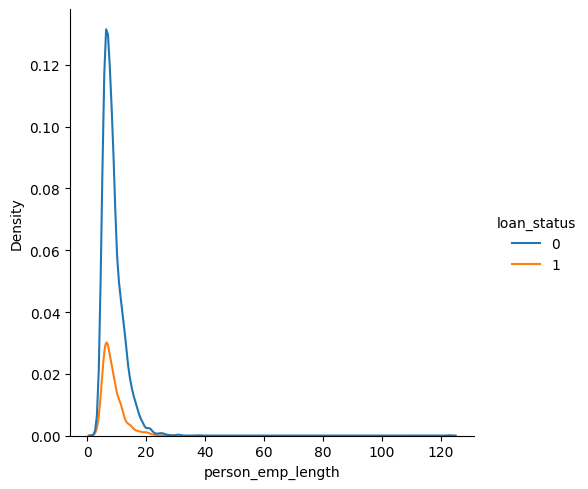

In [34]:
# Distribution plot of person_emp_length of underage_workers by response loan_status
sns.displot(data = data_train[underage_workers],
            x = 'person_emp_length',
            hue = response_variable,
            kind = 'kde')

In [35]:
# Check missing values
data_train['person_emp_length'].isna().sum()

639

**Summary**
- Three-quarters of debtors have worked for 0-7 years, half of the debtors have worked for more than four years.
- About 24% of debtors from the training set are debtors who started working before the age of 18 years.
- There is one invalid data where the employment's length exceeds the debtor's age.

**Pre-processing Plan:**
- Check data integrity: about 24% of debtors start working before 18. Is it valid and acceptable?
- We have 639 missing values.
- Plan A:
  - 'Missing' is grouped separately, and
  - 'Underage workers' is grouped separately if it's not acceptable.
- Plan B:
  - Exclude the underage workers.
  - Impute the missing values with the median.

### Predictor 11: cb_person_default_on_file

In [36]:
# Describe proportion of 'cb_person_default_on_file'
data_train['cb_person_default_on_file'].value_counts(normalize = True)

N    0.822503
Y    0.177497
Name: cb_person_default_on_file, dtype: float64

**Insight**
- 82 % of applicants have default before whereas 18 % never default
- From here, we know that our sample is dominated by customers who never be in default, in a ratio of 82:18.

<AxesSubplot: xlabel='cb_person_default_on_file', ylabel='count'>

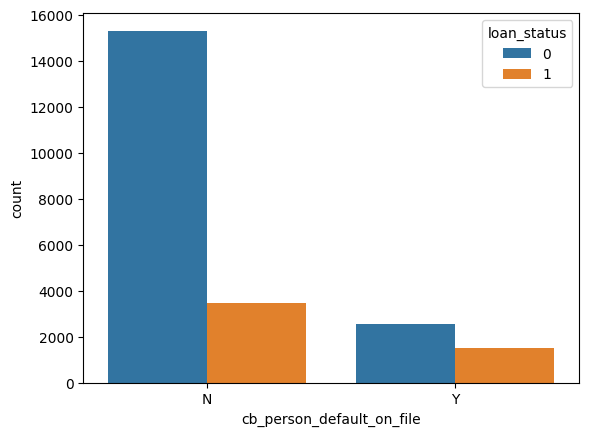

In [37]:
# Describe proportion of default by 'cb_person_default_on_file'
sns.countplot(data = data_train,
              x = 'cb_person_default_on_file',
              hue = response_variable)

Even though the count of defaults from debtors who never default is higher, the higher odds of default seem from those who have been in default before.

Let's check from the contingency table.

In [38]:
# Frequency of default by 'cb_person_default_on_file'
default_by_history = pd.crosstab(data_train['cb_person_default_on_file'],
                                 data_train[response_variable],
                                 margins = False)
default_by_history

loan_status,0,1
cb_person_default_on_file,,
N,15302,3456
Y,2529,1519


In [42]:

default_by_history[0][0]

15302

In [43]:
default_by_history[1][0]

3456

In [39]:
# Odds of default from those who never default
odds_never_default = default_by_history[1][0]/default_by_history[0][0]

# Odds of default from those who have been in default
odds_ever_default = default_by_history[1][1]/default_by_history[0][1]

print("Odds of default from debtors who:")
print(f"never default = {odds_never_default:.2f}")
print(f"ever default = {odds_ever_default:.2f}")

Odds of default from debtors who:
never default = 0.23
ever default = 0.60


**Insight**

- Applicants who have defaulted before have greater odds to be default by 60 % whereas applicants who never be default, have small odds to be default by 23 %
- Then i check with Chi test to check if default and cb_person_default_file are independent event or not

In [44]:
# Import the libraries
import scipy.stats as stats
from scipy.stats import chi2_contingency

# Test whether churn is independent of TV subscriber
stats.chi2_contingency(default_by_history)

# Result of independence test
result = stats.chi2_contingency(default_by_history)

# Extract the test result
stat = result[0]
pval = result[1]

print(f"Chi-stat   : {stat:.4f}")
print(f"P-value    : {pval:.4f}")

Chi-stat   : 711.0770
P-value    : 0.0000


In [45]:
# Create a function of independence test
def independence_test(data, predictor_label, alpha=0.05):
    """
    Funtion to perform the independence test.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    alpha : float in range[0,1], default = 0.05
      Probability of Type I Error (reject H0 when H0 is true).

    """
    # Build the contingency table
    crosstab = pd.crosstab(data[predictor_label],
                           data[response_variable],
                           margins = False)

    # Test whether churn is independent of the predictor
    stats.chi2_contingency(crosstab)

    # Result of independence test
    result = stats.chi2_contingency(crosstab)

    # Extract the test result
    stat = result[0]
    pval = result[1]

    # Print the conclusion
    if pval < alpha:
        print(f"Default and {predictor_label} is not independent with P-val={pval}.")
    else:
        print(f"Default and {predictor_label} is independent with P-val={pval}.")

In [46]:
# Perform the independence test
independence_test(data = data_train,
                  predictor_label = 'cb_person_default_on_file',
                  alpha = 0.05)

Default and cb_person_default_on_file is not independent with P-val=1.166741294176887e-156.


**Insight**
- Based on independence_test, Default and cb_person_default_on_file are dependent event
- About 18% of debtors have a history of defaulting before.
- Debtors who have defaulted before tend to default again afterward.

**Pre-processing Plan:**
- There is no missing values.

## **4. Check Correlation**

Check Correlaition is used to check whether there are **multicollinearity** between predictor variable with pearson correlation

Multicollinearity occurs when **there is a high correlation between two or more predictor variables in a regression model.** This can cause several issues:

1. `Unreliable coefficients:` When multicollinearity is present, it becomes challenging to determine the individual impact of each predictor variable on the dependent variable. The coefficients may be unstable and their direction or magnitude may change when other variables are added or removed from the model.

2. `Reduced model interpretability:` Multicollinearity makes it difficult to interpret the contributions of individual predictors, as they are no longer independent. It blurs the understanding of which predictors are actually influencing the dependent variable.

3. `Increased standard errors:` Multicollinearity inflates the standard errors of the coefficients, making it harder to detect statistically significant relationships between predictors and the dependent variable. This reduces the precision of the estimated coefficients.

4. `Inefficient estimations:` Multicollinearity can lead to inefficient parameter estimations, resulting in less accurate predictions. The model may struggle to distinguish the true relationship between each predictor and the dependent variable.

To address multicollinearity, several steps can be taken:

1. `Investigate correlation:` Identify the variables with high correlation and determine the strength of their relationship. Remove redundant or highly correlated variables from the model.

2. `Feature engineering:` Transform variables or create new ones to capture the same information but with reduced correlation. For example, if two variables have a high correlation, consider creating an interaction term or a ratio between them.

3. `Principal Component Analysis (PCA):` Use dimensionality reduction techniques like PCA to create a smaller set of uncorrelated variables that explain most of the variation in the original predictors.

4. `Ridge regression:` Implement regularization techniques like ridge regression, which adds a penalty to the model's coefficients and can help reduce the impact of multicollinearity.

It is important to address multicollinearity to ensure the model's reliability and interpretability. By identifying and resolving multicollinearity issues, more accurate and reliable results can be obtained from the regression analysis.

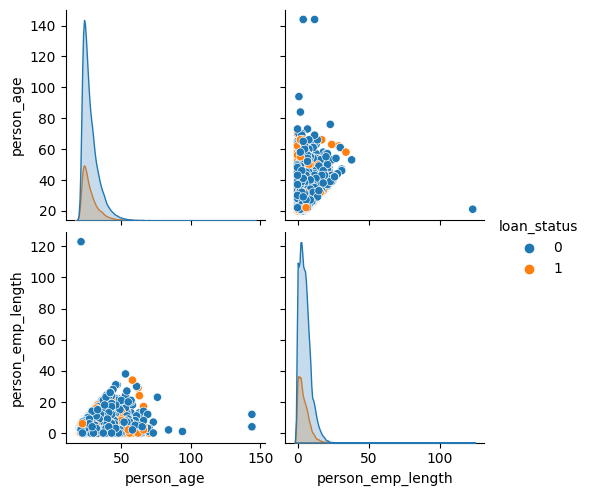

In [47]:
# Check the scatter plot
sns.pairplot(data_train,
             hue = response_variable)

In [48]:
# Calculate Pearson correlation coefficient from numerical predictors
data_train_corr = data_train.corr(method = 'pearson',
                                  numeric_only = True)

data_train_corr

,person_age,person_emp_length,loan_status
person_age,1.000000,0.171397,-0.018554
person_emp_length,0.171397,1.000000,-0.084284
loan_status,-0.018554,-0.084284,1.000000


<AxesSubplot: >

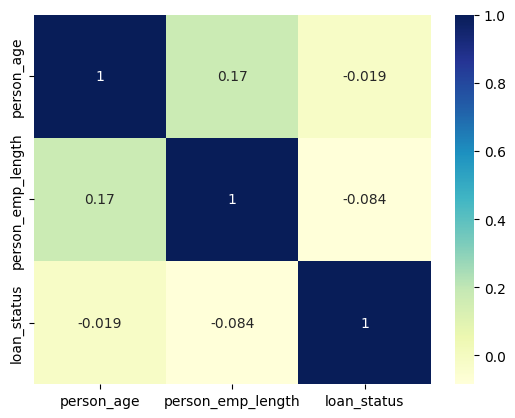

In [49]:
# Plot the heatmap correlation
sns.heatmap(data = data_train_corr,
            cmap = "YlGnBu",
            annot = True)

Based on Pearson correlation, there are not multicollinearity between variable

## 5. Initial Characteristic Analysis ##

We know from EDA that we have missing values and invalid data in a numerical predictor, `person_emp_length`, which is described below :



In [51]:
# Check data integrity
invalid_workers =  data_train['person_emp_length'] > data_train['person_age']

data_train[invalid_workers]

,person_age,person_emp_length,cb_person_default_on_file,loan_status
210,21,123.0,N,0


In [52]:
# Check data integrity
# Check if there any employee is working at age is permitted to working (underage)
# There are 5475 employee is underage
underage_workers = (data_train['person_age'] - data_train['person_emp_length']) < 18

data_train[underage_workers]

,person_age,person_emp_length,cb_person_default_on_file,loan_status
25029,27,11.0,N,0
179,24,8.0,N,0
11278,25,9.0,N,0
13547,22,6.0,N,0
17324,23,7.0,N,1
...,...,...,...,...
13675,26,10.0,N,0
14989,24,8.0,N,0
10023,23,7.0,N,0
1663,22,7.0,N,0


There are two scenarios for the missing values.
- Plan A:
  - 'Missing' is grouped separately, and
  - 'Underage workers' is grouped separately if it's not acceptable.
- Plan B:
  - Exclude the underage workers.
  - Impute the missing values with the median.

Here, we will perform plan A to retain the sample's information as it is.

### **1. Binning**

Create a function for binning the numerical predictors.
- `person_age`
-  `person_emp_length`

In [53]:
# Create a function for binning the numerical predictor
def create_binning(data, predictor_label, num_of_bins):
    """
    Function for binning numerical predictor.

    Parameters
    ----------
    data : array like
      The name of dataset.

    predictor_label : object
      The label of predictor variable.

    num_of_bins : integer
      The number of bins.


    Return
    ------
    data : array like
      The name of transformed dataset.

    """
    data = data.copy()

    # Create a new column containing the binned predictor
    data[predictor_label + "_bin"] = pd.qcut(data[predictor_label],
                                             q = num_of_bins)

    return data

#### Predictor 1: person_age

In [54]:
# Bin person_age
data_train_binned = create_binning(data = data_train,
                                   predictor_label = 'person_age',
                                   num_of_bins = 4)

data_train_binned

,person_age,person_emp_length,cb_person_default_on_file,loan_status,person_age_bin
11491,26,1.0,N,0,"(23.0, 26.0]"
3890,23,3.0,N,0,"(19.999, 23.0]"
17344,24,1.0,N,1,"(23.0, 26.0]"
13023,24,1.0,N,0,"(23.0, 26.0]"
29565,42,4.0,N,1,"(30.0, 144.0]"
...,...,...,...,...,...
22095,32,3.0,N,0,"(30.0, 144.0]"
18736,30,0.0,N,0,"(26.0, 30.0]"
1663,22,7.0,N,0,"(19.999, 23.0]"
18257,29,4.0,Y,0,"(26.0, 30.0]"


In [55]:
# Check the proportion of each bin
data_train_binned['person_age_bin'].value_counts(normalize = True)

(23.0, 26.0]      0.279225
(19.999, 23.0]    0.269227
(30.0, 144.0]     0.237481
(26.0, 30.0]      0.214066
Name: person_age_bin, dtype: float64

In [56]:
# Frequency of default by person_age_bin
crosstab_age = pd.crosstab(data_train_binned['person_age_bin'],
                           data_train_binned[response_variable],
                           margins = True)
crosstab_age

loan_status,0,1,All
person_age_bin,,,
"(19.999, 23.0]",4671,1469,6140
"(23.0, 26.0]",5007,1361,6368
"(26.0, 30.0]",3856,1026,4882
"(30.0, 144.0]",4297,1119,5416
All,17831,4975,22806


#### Predictor 4: person_emp_length

In [57]:
# Bin person_emp_length
data_train_binned = create_binning(data = data_train_binned,
                                   predictor_label = 'person_emp_length',
                                   num_of_bins = 4)

data_train_binned

,person_age,person_emp_length,cb_person_default_on_file,loan_status,person_age_bin,person_emp_length_bin
11491,26,1.0,N,0,"(23.0, 26.0]","(-0.001, 2.0]"
3890,23,3.0,N,0,"(19.999, 23.0]","(2.0, 4.0]"
17344,24,1.0,N,1,"(23.0, 26.0]","(-0.001, 2.0]"
13023,24,1.0,N,0,"(23.0, 26.0]","(-0.001, 2.0]"
29565,42,4.0,N,1,"(30.0, 144.0]","(2.0, 4.0]"
...,...,...,...,...,...,...
22095,32,3.0,N,0,"(30.0, 144.0]","(2.0, 4.0]"
18736,30,0.0,N,0,"(26.0, 30.0]","(-0.001, 2.0]"
1663,22,7.0,N,0,"(19.999, 23.0]","(4.0, 7.0]"
18257,29,4.0,Y,0,"(26.0, 30.0]","(2.0, 4.0]"


In [58]:
# Check the proportion of each bin
data_train_binned['person_emp_length_bin'].value_counts(normalize = True)

(-0.001, 2.0]    0.342130
(4.0, 7.0]       0.247350
(7.0, 123.0]     0.210809
(2.0, 4.0]       0.199711
Name: person_emp_length_bin, dtype: float64

In [ ]:
# Frequency of default by person_age_bin
crosstab_exp = pd.crosstab(data_train_binned['person_emp_length_bin'],
                           data_train_binned[response_variable],
                           margins = True)
crosstab_exp

In [60]:
# Check for missing values
data_train_binned['person_emp_length'].isna().sum()

639

Missing value will be handled through create group that consist of missing value

In [61]:
# Add category 'Missing' to replace the missing values
data_train_binned['person_emp_length_bin'] = data_train_binned['person_emp_length_bin'].cat.add_categories('Missing')

# Replace missing values with category 'Missing'
data_train_binned['person_emp_length_bin'].fillna(value = 'Missing',
                                                  inplace = True)

In [62]:
# Sanity check
data_train_binned['person_emp_length_bin'].isna().sum()

0

In [63]:
# Check the proportion of each bin
data_train_binned['person_emp_length_bin'].value_counts(normalize = True)

(-0.001, 2.0]    0.332544
(4.0, 7.0]       0.240419
(7.0, 123.0]     0.204902
(2.0, 4.0]       0.194116
Missing          0.028019
Name: person_emp_length_bin, dtype: float64

In [64]:
# Frequency of default by person_emp_length
crosstab_emp_length = pd.crosstab(data_train_binned['person_emp_length_bin'],
                                  data_train_binned[response_variable],
                                  margins = True)
crosstab_emp_length

loan_status,0,1,All
person_emp_length_bin,,,
"(-0.001, 2.0]",5533,2051,7584
"(2.0, 4.0]",3510,917,4427
"(4.0, 7.0]",4460,1023,5483
"(7.0, 123.0]",3885,788,4673
Missing,443,196,639
All,17831,4975,22806


### **2. WoE and IV**
---  
To assess the strength of each characteristic individually as a predictor of the credit performance.

- Weight of Evidence (WoE) — measures the strength of each attribute.

$$
\begin{align*}
W_i &= \ln ( \% \text{Good} / \% \text{Bad} ) \\
W_i &= \ln \left ( \left ( \frac{N_i}{\sum N} \right ) / \left ( \frac{P_i}{\sum P} \right )\right ) \\
\end{align*}
$$

- Information Value (IV) — measures the total strength of the characteristic.

$$
\begin{align*}
IV &= \sum_{i=1}^{n} ( \% \text{Good} - \% \text{Bad} ) \times W_i \\
IV &= \sum_{i=1}^{n}\left [ \left ( \frac{N_i}{\sum N} - \frac{P_i}{\sum P} \right ) \times W_i \right ] \\
\end{align*}
$$

#### Predictor 1: person_age

---

In [65]:
# Display the crosstab
crosstab_age

loan_status,0,1,All
person_age_bin,,,
"(19.999, 23.0]",4671,1469,6140
"(23.0, 26.0]",5007,1361,6368
"(26.0, 30.0]",3856,1026,4882
"(30.0, 144.0]",4297,1119,5416
All,17831,4975,22806


In [66]:
# Calculate % Good
crosstab_age['p_good'] = crosstab_age[0]/crosstab_age[0]['All']

# Calculate % Bad
crosstab_age['p_bad'] = crosstab_age[1]/crosstab_age[1]['All']

# Calculate the WOE
crosstab_age['WOE'] = np.log(crosstab_age['p_good']/crosstab_age['p_bad'])

# Calculate the contribution value for IV
crosstab_age['contribution'] = (crosstab_age['p_good']-crosstab_age['p_bad'])*crosstab_age['WOE']

person_age_bin
(19.999, 23.0]     4671
(23.0, 26.0]       5007
(26.0, 30.0]       3856
(30.0, 144.0]      4297
All               17831
Name: 0, dtype: int64

In [67]:
# Display the result
crosstab_age

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_age_bin,,,,,,,
"(19.999, 23.0]",4671,1469,6140,0.261960,0.295276,-0.119722,0.003989
"(23.0, 26.0]",5007,1361,6368,0.280803,0.273568,0.026104,0.000189
"(26.0, 30.0]",3856,1026,4882,0.216253,0.206231,0.047449,0.000476
"(30.0, 144.0]",4297,1119,5416,0.240985,0.224925,0.068969,0.001108
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [68]:
# Calculate the IV
IV_age = crosstab_age['contribution'][:-1].sum()
IV_age

0.0057607866468167455

In [70]:
# Create a function to calculate the WOE and IV
def WOE_IV(crosstab):
    """
    Function to calculate WOE and IV.

    Parameters
    ----------
    crosstab : DataFrame
      The cross tabulation between characteristic and response variable.

    Return
    ------
    crosstab : DataFrame
      The crosstab with additional information of WOE.
    IV : float
      The infromation value of the characteristic.

    """
    # Calculate % Good
    crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

    # Calculate % Bad
    crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

    # Calculate the WOE
    crosstab['WOE'] = np.log(crosstab['p_good']/crosstab['p_bad'])

    # Calculate the contribution value for IV
    crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']

    # Calculate the IV
    IV = crosstab['contribution'][:-1].sum()

    return crosstab, IV

In [72]:
# Check the function
crosstab_age, IV_age = WOE_IV(crosstab = crosstab_age)

In [73]:
# Display the result
crosstab_age

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_age_bin,,,,,,,
"(19.999, 23.0]",4671,1469,6140,0.261960,0.295276,-0.119722,0.003989
"(23.0, 26.0]",5007,1361,6368,0.280803,0.273568,0.026104,0.000189
"(26.0, 30.0]",3856,1026,4882,0.216253,0.206231,0.047449,0.000476
"(30.0, 144.0]",4297,1119,5416,0.240985,0.224925,0.068969,0.001108
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [74]:
# Check the IV
IV_age

0.0057607866468167455

In [75]:
# Summarize the IV in a table
IV_table = pd.DataFrame({'Characteristic': 'person_age',
                         'Information Value' : [IV_age]})

IV_table

,Characteristic,Information Value
0,person_age,0.005761


#### Predictor 1: person_age

---

In [76]:
# Display the crosstab
crosstab_emp_length

loan_status,0,1,All
person_emp_length_bin,,,
"(-0.001, 2.0]",5533,2051,7584
"(2.0, 4.0]",3510,917,4427
"(4.0, 7.0]",4460,1023,5483
"(7.0, 123.0]",3885,788,4673
Missing,443,196,639
All,17831,4975,22806


In [77]:
# Calculate the WOE and IV
crosstab_emp_length, IV_emp_length = WOE_IV(crosstab = crosstab_emp_length)

In [78]:
# Display the result
crosstab_emp_length

loan_status,0,1,All,p_good,p_bad,WOE,contribution
person_emp_length_bin,,,,,,,
"(-0.001, 2.0]",5533,2051,7584,0.310302,0.412261,-0.284110,0.028968
"(2.0, 4.0]",3510,917,4427,0.196848,0.184322,0.065751,0.000824
"(4.0, 7.0]",4460,1023,5483,0.250126,0.205628,0.195896,0.008717
"(7.0, 123.0]",3885,788,4673,0.217879,0.158392,0.318867,0.018968
Missing,443,196,639,0.024844,0.039397,-0.461058,0.006710
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [79]:
# Check the IV
IV_emp_length

0.06418629798051112

In [80]:
# Summarize in IV Table
add_IV_emp_length = {'Characteristic': 'person_emp_length',
                     'Information Value' : IV_emp_length}

IV_table = IV_table.append(add_IV_emp_length,
                           ignore_index = True)

IV_table

/var/folders/k1/y02_gdyx4b54pph7np3s3yd80000gn/T/ipykernel_1323/3143653413.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IV_table = IV_table.append(add_IV_emp_length,


,Characteristic,Information Value
0,person_age,0.005761
1,person_emp_length,0.064186


#### Predictor 11: cb_person_default_on_file

In [81]:
# Create crosstab of 'cb_person_default_on_file'
crosstab_default_history = pd.crosstab(data_train['cb_person_default_on_file'],
                                       data_train['loan_status'],
                                       margins = True)
crosstab_default_history

loan_status,0,1,All
cb_person_default_on_file,,,
N,15302,3456,18758
Y,2529,1519,4048
All,17831,4975,22806


In [82]:
# Calculate the WOE and IV
crosstab_default_history, IV_default_history = WOE_IV(crosstab = crosstab_default_history)

In [83]:
# Display the result
crosstab_default_history

loan_status,0,1,All,p_good,p_bad,WOE,contribution
cb_person_default_on_file,,,,,,,
N,15302,3456,18758,0.858168,0.694673,0.211359,0.034556
Y,2529,1519,4048,0.141832,0.305327,-0.766741,0.125358
All,17831,4975,22806,1.000000,1.000000,0.000000,0.000000


In [84]:
# Check the IV
IV_default_history

0.15991444213621012

In [85]:
# Summarize in IV Table
add_IV_default_history = {'Characteristic': 'cb_person_default_on_file',
                          'Information Value' : IV_default_history}

IV_table = IV_table.append(add_IV_default_history,
                           ignore_index = True)

IV_table

/var/folders/k1/y02_gdyx4b54pph7np3s3yd80000gn/T/ipykernel_1323/336915987.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  IV_table = IV_table.append(add_IV_default_history,


,Characteristic,Information Value
0,person_age,0.005761
1,person_emp_length,0.064186
2,cb_person_default_on_file,0.159914


### **3. Check Logical Trend and Business Consideration**
---

In grouped scorecards, the attribute strengths must also be in a logical order, and make operational sense.

In [86]:
# Create a funtion to plot the WOE
def plot_WOE(crosstab):
  """
  Function to plot the WOE trend.

  Parameters
  ----------
  crosstab : DataFrame
    The cross tabulation of the characteristic.

  """
  # Define the plot size
  plt.figure(figsize = (8,4))

  # Plot the WOE
  sns.pointplot(x = crosstab.T.columns,
                y = 'WOE',
                data = crosstab,
                markers = 'o',
                linestyles = '--',
                color = 'blue')

  # Rotate the label of x-axis
  plt.xticks(rotation = 20)

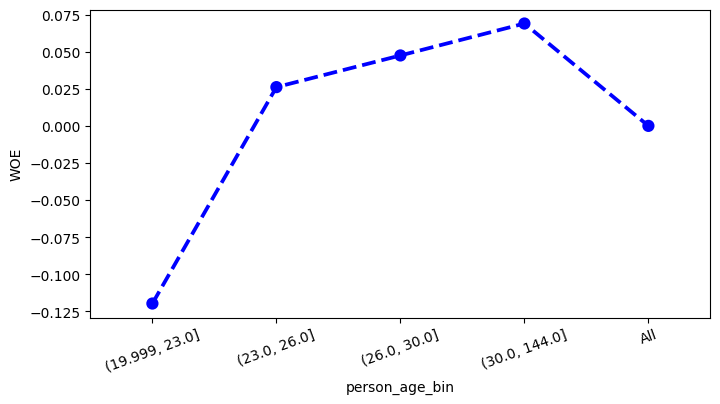

In [87]:
# Plot the WOE of  person_age
plot_WOE(crosstab_age)

- Younger debtors tend to be generally of a higher risk than older debtors.
- Does this make sense in operational or business?

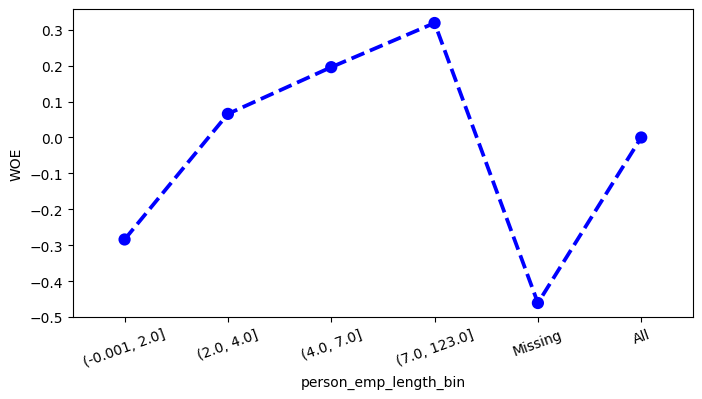

In [88]:
# Plot the WoE of person_emp_length
plot_WOE(crosstab_emp_length)

- The higher odds of default seem from those who have been in default before.
- Does this make sense in operational or business?